# Web Server Performance Analysis: Apache vs Nginx

## NSPNAO2025 Lab Week 05 - Performance Evaluation

This notebook performs comprehensive statistical analysis and visualization of Apache and Nginx web server performance under different resource constraints and concurrent user loads.

### Experimental Design:
- **Scenario A**: 0.5 CPU cores, 512MB RAM
- **Scenario B**: 1.0 CPU core, 512MB RAM
- **Load Levels**: 100, 500, 1000, 2500, 5000 VUs (Virtual Users)
- **Duration**: 120 seconds per test (30s ramp-up, 60s steady state, 30s ramp-down)

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading Functions

In [2]:
def load_k6_csv(file_path):
    """
    Load k6 CSV results file.
    
    Args:
        file_path: Path to k6 CSV file
        
    Returns:
        DataFrame with k6 metrics
    """
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

def parse_summary_file(file_path):
    """
    Parse k6 summary text file to extract key metrics.
    
    Args:
        file_path: Path to summary text file
        
    Returns:
        Dictionary with parsed metrics
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
    
    metrics = {}
    
    # Extract http_req_duration metrics
    if 'http_req_duration' in content:
        line = [l for l in content.split('\n') if 'http_req_duration' in l and 'avg=' in l][0]
        parts = line.split()
        for part in parts:
            if 'avg=' in part:
                metrics['avg_duration'] = parse_duration(part.split('=')[1])
            elif 'p(95)=' in part:
                metrics['p95_duration'] = parse_duration(part.split('=')[1])
            elif 'p(90)=' in part:
                metrics['p90_duration'] = parse_duration(part.split('=')[1])
            elif 'max=' in part:
                metrics['max_duration'] = parse_duration(part.split('=')[1])
            elif 'min=' in part:
                metrics['min_duration'] = parse_duration(part.split('=')[1])
            elif 'med=' in part:
                metrics['med_duration'] = parse_duration(part.split('=')[1])
    
    # Extract http_reqs (throughput)
    if 'http_reqs' in content:
        line = [l for l in content.split('\n') if l.strip().startswith('http_reqs')][0]
        parts = line.split()
        if len(parts) >= 3:
            metrics['total_requests'] = int(parts[1])
            metrics['throughput'] = float(parts[2].replace('/s', ''))
    
    # Extract http_req_failed (error rate)
    if 'http_req_failed' in content:
        line = [l for l in content.split('\n') if l.strip().startswith('http_req_failed')][0]
        parts = line.split()
        if len(parts) >= 2:
            metrics['error_rate'] = float(parts[1].replace('%', '').replace(':', ''))
    
    # Extract checks
    if 'checks_succeeded' in content:
        line = [l for l in content.split('\n') if 'checks_succeeded' in l][0]
        parts = line.split()
        if len(parts) >= 2:
            metrics['checks_success_rate'] = float(parts[1].replace('%', '').replace(':', ''))
    
    return metrics

def parse_duration(duration_str):
    """
    Parse duration string from k6 output (e.g., '1.16ms', '2s', '31.29ms').
    
    Args:
        duration_str: Duration string
        
    Returns:
        Duration in milliseconds
    """
    duration_str = duration_str.strip()
    
    if 'ms' in duration_str:
        return float(duration_str.replace('ms', ''))
    elif 'µs' in duration_str or 'us' in duration_str:
        return float(duration_str.replace('µs', '').replace('us', '')) / 1000
    elif 'm' in duration_str:
        (minute, may_be_seconds) = duration_str.split("m")
        if not may_be_seconds:
            return float(minute) * 60
        return float(minute) * 60 + float(may_be_seconds[:-1])
    elif 's' in duration_str:
        return float(duration_str.replace('s', '')) * 1000
    elif 'µ' in duration_str:
        return float(duration_str.replace('µ', '')) / 1000
    else:
        return float(duration_str)

print("Data loading functions defined!")

Data loading functions defined!


## 3. Load All Test Results

In [7]:
# Define test parameters
results_dir = Path('results')
cpu_scenarios = ['cpu_0.5', 'cpu_1.0']
vu_levels = [100, 500, 1000, 2500, 5000]
servers = ['apache', 'nginx']

# Load all CSV data and calculate statistics from individual request measurements
all_results = []

for cpu_scenario in cpu_scenarios:
    cpu_limit = float(cpu_scenario.replace('cpu_', ''))
    
    for vus in vu_levels:
        vus_dir = results_dir / cpu_scenario / f'vus_{vus}'
        
        for server in servers:
            # Look for CSV files with pattern: {server}_{cpu}_{vus}.csv
            csv_pattern = f'{server}_{cpu_limit}_{vus}.csv'
            csv_file = vus_dir / csv_pattern
            
            if csv_file.exists():
                try:
                    # Load CSV file
                    df_raw = load_k6_csv(csv_file)
                    
                    # Extract http_req_duration measurements (individual request response times)
                    duration_data = df_raw[df_raw['metric_name'] == 'http_req_duration']

                    success_duration_data = duration_data[duration_data["status"] == 200]
                    
                    # Extract http_req_failed measurements (for error rate)
                    failed_data = df_raw[df_raw['metric_name'] == 'http_req_failed']
                    
                    # Calculate test duration (max timestamp - min timestamp)
                    test_duration = (df_raw['timestamp'].max() - df_raw['timestamp'].min()).total_seconds()

                    total_requests = len(duration_data['metric_value'])
                    failed_requests = len(failed_data['metric_value'])
                    
                    # Calculate statistics from raw measurements
                    if len(duration_data["metric_value"]) > 0:
                        metrics = {
                            'server': server,
                            'cpu_limit': cpu_limit,
                            'vus': vus,
                            'scenario': f'{cpu_limit} CPU',
                            'total_requests': total_requests,
                            "success_requests": total_requests - failed_requests,
                            "failed_requests": failed_requests,
                            'mean_duration': duration_data["metric_value"].mean(),
                            'std_duration': duration_data["metric_value"].std(),
                            "success_mean_duration": success_duration_data["metric_value"].mean(),
                            "success_std_duration": success_duration_data["metric_value"].std(),
                            # 'min_duration': duration_data.min(),
                            # 'max_duration': duration_data.max(),
                            # 'med_duration': duration_data.median(),
                            # 'p90_duration': duration_data.quantile(0.90),
                            'p95_duration': duration_data["metric_value"].quantile(0.95),
                            'p99_duration': duration_data["metric_value"].quantile(0.99),
                            "test_duration": test_duration,
                            # 'throughput': len(duration_data) / test_duration if test_duration > 0 else 0,
                            # 'error_rate': (failed_data.sum() / len(failed_data) * 100) if len(failed_data) > 0 else 0,
                        }
                        all_results.append(metrics)
                        
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
            else:
                print(f"Warning: CSV file not found: {csv_file}")

# Create DataFrame
df_results = pd.DataFrame(all_results)

# Display the loaded data
print(f"\nLoaded {len(df_results)} test results from CSV files")
print(f"\nColumns: {', '.join(df_results.columns)}")
print(f"\nData shape: {df_results.shape}")
print(f"\nSample statistics (first test):")
if len(df_results) > 0:
    print(f"  - Requests measured: {df_results.iloc[0]['total_requests']:.0f}")
    # print(f"  - Avg duration: {df_results.iloc[0]['avg_duration']:.3f} ms (±{df_results.iloc[0]['std_duration']:.3f})")
    # print(f"  - P95 duration: {df_results.iloc[0]['p95_duration']:.3f} ms")
print()
df_results


Loaded 20 test results from CSV files

Columns: server, cpu_limit, vus, scenario, total_requests, success_requests, failed_requests, mean_duration, std_duration, success_mean_duration, success_std_duration, p95_duration, p99_duration, test_duration

Data shape: (20, 14)

Sample statistics (first test):
  - Requests measured: 7199



,server,cpu_limit,vus,scenario,total_requests,success_requests,failed_requests,mean_duration,std_duration,success_mean_duration,success_std_duration,p95_duration,p99_duration,test_duration
0,apache,0.5,100,0.5 CPU,7199,0,7199,1.164906,1.223432,1.164906,1.223432,2.710010,5.254204,120.0
1,nginx,0.5,100,0.5 CPU,7240,0,7240,2.166843,5.686595,2.166843,5.686595,5.633655,13.068192,120.0
2,apache,0.5,500,0.5 CPU,36283,0,36283,0.761393,1.165866,0.761393,1.165866,1.447370,4.135766,121.0
3,nginx,0.5,500,0.5 CPU,36203,0,36203,0.726490,1.242616,0.726490,1.242616,1.238850,3.798376,121.0
4,apache,0.5,1000,0.5 CPU,72397,0,72397,0.841698,1.668281,0.841698,1.668281,1.652940,7.613400,122.0
5,nginx,0.5,1000,0.5 CPU,72553,0,72553,0.802381,1.782607,0.802381,1.782607,1.568400,7.514736,121.0
6,apache,0.5,2500,0.5 CPU,102440,0,102440,1148.295006,7694.876108,377.709200,3747.335777,3.272680,59998.743235,126.0
7,nginx,0.5,2500,0.5 CPU,181245,0,181245,0.871297,2.062455,0.871297,2.062455,1.592500,10.856552,122.0
8,apache,0.5,5000,0.5 CPU,112298,0,112298,3131.012270,12857.608665,674.009745,5167.208640,39976.427460,59999.383918,136.0
9,nginx,0.5,5000,0.5 CPU,357589,0,357589,15.966028,93.000230,15.966028,93.000230,52.104180,545.298328,122.0


## [คำตอบ] ขั้นตอนที่ 8: Design Experiment (ออกแบบและเตรียมการทดลอง)

### ตารางที่ 8.1: การทดสอบรอบที่ 1

บันทึกผลการทดสอบเมื่อจำกัด CPU ไว้ที่ 0.5 Core

In [ ]:
server_sort = {'apache': 0, 'nginx': 1}

def format_answer_8(df: pd.DataFrame):
    return df.sort_values(
        by='server',
        key=lambda x: x.map(server_sort),
        ignore_index=True
    ).drop(columns=["cpu_limit"]).head(20)

In [ ]:
format_answer_8(df_results[df_results["cpu_limit"] == 0.5])

,server,vus,scenario,total_requests,success_requests,failed_requests,mean_duration,std_duration,success_mean_duration,success_std_duration
0,apache,100,0.5 CPU,7199,0,7199,1.164906,1.223432,1.164906,1.223432
1,apache,500,0.5 CPU,36283,0,36283,0.761393,1.165866,0.761393,1.165866
2,apache,2500,0.5 CPU,102440,0,102440,1148.295006,7694.876108,377.709200,3747.335777
3,apache,1000,0.5 CPU,72397,0,72397,0.841698,1.668281,0.841698,1.668281
4,apache,5000,0.5 CPU,112298,0,112298,3131.012270,12857.608665,674.009745,5167.208640
5,nginx,500,0.5 CPU,36203,0,36203,0.726490,1.242616,0.726490,1.242616
6,nginx,1000,0.5 CPU,72553,0,72553,0.802381,1.782607,0.802381,1.782607
7,nginx,100,0.5 CPU,7240,0,7240,2.166843,5.686595,2.166843,5.686595
8,nginx,2500,0.5 CPU,181245,0,181245,0.871297,2.062455,0.871297,2.062455
9,nginx,5000,0.5 CPU,357589,0,357589,15.966028,93.000230,15.966028,93.000230


### ตารางที่ 8.2: การทดสอบรอบที่ 1

บันทึกผลการทดสอบเมื่อจำกัด CPU ไว้ที่ 1.0 Core

In [ ]:
format_answer_8(df_results[df_results["cpu_limit"] == 1.0])

,server,vus,scenario,total_requests,success_requests,failed_requests,mean_duration,std_duration,success_mean_duration,success_std_duration
0,apache,100,1.0 CPU,7254,0,7254,1.280396,0.899930,1.280396,0.899930
1,apache,500,1.0 CPU,36242,0,36242,0.762299,1.102378,0.762299,1.102378
2,apache,2500,1.0 CPU,103240,0,103240,1135.913977,7645.593606,377.060163,3736.767337
3,apache,1000,1.0 CPU,72557,0,72557,0.723928,1.278048,0.723928,1.278048
4,apache,5000,1.0 CPU,112684,0,112684,3177.667178,12985.622076,668.235757,5213.868390
5,nginx,500,1.0 CPU,36289,0,36289,0.679066,0.901291,0.679066,0.901291
6,nginx,1000,1.0 CPU,72433,0,72433,0.717752,1.308848,0.717752,1.308848
7,nginx,100,1.0 CPU,7247,0,7247,1.223717,0.868286,1.223717,0.868286
8,nginx,2500,1.0 CPU,181037,0,181037,1.262209,3.945342,1.262209,3.945342
9,nginx,5000,1.0 CPU,361389,0,361389,4.108014,16.956417,4.108014,16.956417


## ขั้นตอนที่ 9: Analyze and Intepret Data (วิเคราะห์และแปลผลข้อมูล)

ใช้ค่าจากตารางผลทดลอง (เช่น Total Requests, Mean, Std Dev) ที่ได้จากขั้นตอนที่ 8 โดยในวิธีคำนวณของแลปกำหนดว่า กำหนดให้ใช้ **Z-distribution** (เพราะ n > 30) และใช้สูตร

$$
CI = \bar{x} \pm z_{1-\alpha/2} \left( \frac{s}{\sqrt{n}} \right)
$$

- $\bar{x}$ bar = Mean response time
- $n$ = Total Requests
- $s$ = Standard deviation estimate
- $z$ ที่ 95% = 1.96

> **สำคัญ:** ก่อนคำนวณให้ทำให้ “หน่วย" ของ Mean กับ Std Dev สอดคล้องกัน (แลปมี Mean เป็น ms และ Std Dev แสดงเป็น s ในตารางผลทดลอง) เพื่อไม่ให้ CI เพี้ยน

**Note 1!** ที่ความเชื่อมั่น 95% ค่า $\alpha$ = 0.05 เปิดหาตารางที่ $1 - \frac{\alpha}{2}$ = 0.975

**Note 2!** การคำนวณ Standard Distribution ของ **ประชากร** ให้ใช้สูตร

$$
s = \sqrt{\frac{\sum_i{|a_i - \bar{a}|^2 }}{N - 1}}
$$

*ตัว $-1$ ที่ใส่เพิ่มไปนี้ อาจหมายถึง **Degree of Freedom** ก็ได้*

**Note 3!** ก้อนนี้ $ z_{1-\alpha/2} \left( \frac{s}{\sqrt{n}} \right)$ อาจเรียกอีกชื่อว่า **Confidence Level** หรือ **Margin of Error**

In [ ]:
def calcaulte_z_critical(confidence):
    return stats.norm.ppf((1 + confidence) / 2)

print("z =", calcaulte_z_critical(confidence=0.95))

z = 1.959963984540054


### 9.1 รวบรวมข้อมูลดิบ (Data Collection)

สรุปผลลัพธ์ที่ได้จากการทดลองทั้ง 10 รอบลงในตารางนี้ เพื่อให้เห็นภาพรวมเปรียบเทียบกันชัดเจน

In [ ]:
def calculate_confidence_interval(df, confidence=0.95):
    # ค่า std, n ใช้จากที่มีอยู่แล้ว
    n = df["total_requests"]
    std = df["success_std_duration"]
    mean = df["success_mean_duration"]
    
    confidence_level = calcaulte_z_critical(confidence) * (std / np.sqrt(n))

    # Confidence Interval คือ ช่วง ดังนั้นจะมีช่วงเปิดและปิด
    lower_bound = mean - confidence_level
    upper_bound = mean + confidence_level
    confidence_interval = (lower_bound, upper_bound)

    return mean, confidence_level, confidence_interval

In [ ]:
from typing import Dict, Tuple

Interval = Tuple[float, float, float]

def compare_intervals(intervals: Dict[str, Interval]):
    if len(intervals) != 2:
        raise ValueError("Exactly two intervals are required")

    (key1, a), (key2, b) = intervals.items()
    lower_a, upper_a = a
    lower_b, upper_b = b

    # Overlap check
    if upper_a >= lower_b and upper_b >= lower_a:
        return "overlap", 0

    # No overlap: return which interval is upper
    if lower_a > upper_b:
        return key1, lower_a - upper_b
    else:
        return key2, lower_b - upper_a

In [ ]:
class ConfidenceInterval:
    LOWER = "ci_lower_bound"
    UPPER = "ci_upper_bound"
    
    @staticmethod
    def get_tuple(df: pd.DataFrame):
        return (df[ConfidenceInterval.LOWER], df[ConfidenceInterval.UPPER])

    @staticmethod
    def set_tuple(df: pd.DataFrame, interval: tuple[int, int]):
        lower, upper = interval
        df[ConfidenceInterval.LOWER] = lower
        df[ConfidenceInterval.UPPER] = upper
        return df

#### ตาราง 9.1: CI Calculation Results — CPU Limit = 0.5 Core

In [ ]:
def format_answer_9(df: pd.DataFrame, confidence=0.95):
    # เรียงคอลัมน์ใหม่
    df_out = df[["vus", "server", "success_mean_duration", "total_requests", "success_std_duration"]].reset_index(drop=True)
    
    """
    Goal 1: Calculate 95% CI
    """

    mean, confidence_level, confidence_interval = calculate_confidence_interval(
        df.reset_index(drop=True),
        confidence
    )  

    df_out["confidence_level"] = confidence_level
    ConfidenceInterval.set_tuple(df_out, confidence_interval)

    """
    Goal 2: Find overlapping in Confidence Interval
    """
    # สังเกตจาก Pattern ของข้อมูลว่า Apache จะมาก่อน Nginx และจะมาคู่กัน
    # คำนวณทุก ๆ ครั้งที่เจอ Nginx (aka เริีมที่ 1 จบที่อันสุดท้าย เพิ่มทีละ 2 จ้า)
    for i in range(1, len(df), 2):
        apache = df_out.iloc[i - 1]
        nginx = df_out.iloc[i]
        who_is_upper, delta_overlap = compare_intervals({
            "apache": ConfidenceInterval.get_tuple(apache),
            "nginx": ConfidenceInterval.get_tuple(nginx),
        })

        if who_is_upper == "overlap":
            df_out.loc[i-1:i, "is_overlapping"] = "overlap"
        else:
            # ยิ่งเยอะยิ่งไม่ดี (Lower is Better)
            df_out.loc[i-1:i, "is_overlapping"] = "nginx_better" if who_is_upper == "apache" else "apache_better"

        df_out.loc[i-1:i, "delta_overlap"] = delta_overlap
    return df_out


df_ci_results_cpu05 = format_answer_9(df_results[df_results["cpu_limit"] == 0.5])
df_ci_results_cpu05

,vus,server,success_mean_duration,total_requests,success_std_duration,confidence_level,ci_lower_bound,ci_upper_bound,is_overlapping,delta_overlap
0,100,apache,1.164906,7199,1.223432,0.028261,1.136645,1.193167,apache_better,0.842688
1,100,nginx,2.166843,7240,5.686595,0.130988,2.035855,2.297831,apache_better,0.842688
2,500,apache,0.761393,36283,1.165866,0.011996,0.749397,0.773390,nginx_better,0.010107
3,500,nginx,0.726490,36203,1.242616,0.012800,0.713690,0.739290,nginx_better,0.010107
4,1000,apache,0.841698,72397,1.668281,0.012152,0.829546,0.853850,nginx_better,0.014194
5,1000,nginx,0.802381,72553,1.782607,0.012971,0.789410,0.815352,nginx_better,0.014194
6,2500,apache,377.709200,102440,3747.335777,22.947528,354.761672,400.656729,nginx_better,353.880880
7,2500,nginx,0.871297,181245,2.062455,0.009495,0.861802,0.880792,nginx_better,353.880880
8,5000,apache,674.009745,112298,5167.208640,30.221643,643.788101,704.231388,nginx_better,627.517256
9,5000,nginx,15.966028,357589,93.000230,0.304818,15.661210,16.270845,nginx_better,627.517256


#### ตาราง 9.12 CI Calculation Results — CPU Limit = 1.0 Core

In [ ]:
df_ci_results_cpu10 = format_answer_9(df_results[df_results["cpu_limit"] == 1.0])
df_ci_results_cpu10

,vus,server,success_mean_duration,total_requests,success_std_duration,confidence_level,ci_lower_bound,ci_upper_bound,is_overlapping,delta_overlap
0,100,apache,1.280396,7254,0.899930,0.020709,1.259686,1.301105,nginx_better,0.015979
1,100,nginx,1.223717,7247,0.868286,0.019991,1.203726,1.243708,nginx_better,0.015979
2,500,apache,0.762299,36242,1.102378,0.011349,0.750949,0.773648,nginx_better,0.062610
3,500,nginx,0.679066,36289,0.901291,0.009273,0.669793,0.688339,nginx_better,0.062610
4,1000,apache,0.723928,72557,1.278048,0.009299,0.714629,0.733228,overlap,0.000000
5,1000,nginx,0.717752,72433,1.308848,0.009532,0.708220,0.727284,overlap,0.000000
6,2500,apache,377.060163,103240,3736.767337,22.793979,354.266183,399.854142,nginx_better,352.985800
7,2500,nginx,1.262209,181037,3.945342,0.018174,1.244035,1.280383,nginx_better,352.985800
8,5000,apache,668.235757,112684,5213.868390,30.442270,637.793487,698.678027,nginx_better,633.630190
9,5000,nginx,4.108014,361389,16.956417,0.055283,4.052731,4.163297,nginx_better,633.630190


## ขั้นตอนที่ 10: Present Results (นำเสนอผล + ข้อจำกัด)

### 10.1 ภาพรวมผลการทดลอง (Overall Results Overview)

จากผลการทดลองพบว่า Performance ของ Apache และ Nginx มีพฤติกรรมแตกต่างกันตามระดับ Load และ Resource Constraint ที่กำหนด โดยเฉพาะในช่วง High Load ซึ่งเป็นช่วงที่ระบบเข้าใกล้ขีดจำกัดของทรัพยากร (System Capacity) ความแตกต่างของ Mean Response Time และ 95% Confidence Interval สามารถสังเกตได้ชัดเจนยิ่งขึ้น

การเพิ่ม CPU จาก 0.5 Core เป็น 1.0 Core ส่งผลให้ทั้งสอง Web Server รองรับ Load ได้ดีขึ้น อย่างไรก็ตาม ระดับการปรับตัวและเสถียรภาพของระบบยังคงแตกต่างกันระหว่าง Apache และ Nginx

#### ตาราง 10.1: Visual Hypothesis Testing Summary — CPU 0.5 Core

In [ ]:
def format_answer_10(df: pd.DataFrame):
    # ลบคอลัมน์ที่ซ้ำออก
    df_out = df[["vus", "is_overlapping", "delta_overlap"]].drop_duplicates()
    # เพื่อดูว่าต่างอย่างมีนัยสำคัญหรือไม่ เราใช้วิธีประมาณเอาว่า มันเกินค่าเฉลี่ย หรือเกิน percentile ที่กำหนดมั้ย
    significant_theshold = df["delta_overlap"].quantile(0.60)
    df_out.insert(2, "is_significantly_overlap", df["delta_overlap"] > significant_theshold)
    return df_out

format_answer_10(df_ci_results_cpu05)

,vus,is_overlapping,is_significantly_overlap,delta_overlap
0,100,apache_better,False,0.842688
2,500,nginx_better,False,0.010107
4,1000,nginx_better,False,0.014194
6,2500,nginx_better,True,353.880880
8,5000,nginx_better,True,627.517256


#### ตาราง 10.2: Visual Hypothesis Testing Summary — CPU 1.0 Core

In [ ]:
format_answer_10(df_ci_results_cpu10)

,vus,is_overlapping,is_significantly_overlap,delta_overlap
0,100,nginx_better,False,0.015979
2,500,nginx_better,False,0.062610
4,1000,overlap,False,0.000000
6,2500,nginx_better,True,352.985800
8,5000,nginx_better,True,633.630190


## 9. Statistical Significance Testing with Confidence Intervals

In [ ]:
df_results[df_results["server"] == "apache"]

,server,cpu_limit,vus,scenario,total_requests,success_requests,failed_requests,mean_duration,std_duration,success_mean_duration,success_std_duration
0,apache,0.5,100,0.5 CPU,7199,0,7199,1.164906,1.223432,1.164906,1.223432
2,apache,0.5,500,0.5 CPU,36283,0,36283,0.761393,1.165866,0.761393,1.165866
4,apache,0.5,1000,0.5 CPU,72397,0,72397,0.841698,1.668281,0.841698,1.668281
6,apache,0.5,2500,0.5 CPU,102440,0,102440,1148.295006,7694.876108,377.709200,3747.335777
8,apache,0.5,5000,0.5 CPU,112298,0,112298,3131.012270,12857.608665,674.009745,5167.208640
10,apache,1.0,100,1.0 CPU,7254,0,7254,1.280396,0.899930,1.280396,0.899930
12,apache,1.0,500,1.0 CPU,36242,0,36242,0.762299,1.102378,0.762299,1.102378
14,apache,1.0,1000,1.0 CPU,72557,0,72557,0.723928,1.278048,0.723928,1.278048
16,apache,1.0,2500,1.0 CPU,103240,0,103240,1135.913977,7645.593606,377.060163,3736.767337
18,apache,1.0,5000,1.0 CPU,112684,0,112684,3177.667178,12985.622076,668.235757,5213.868390


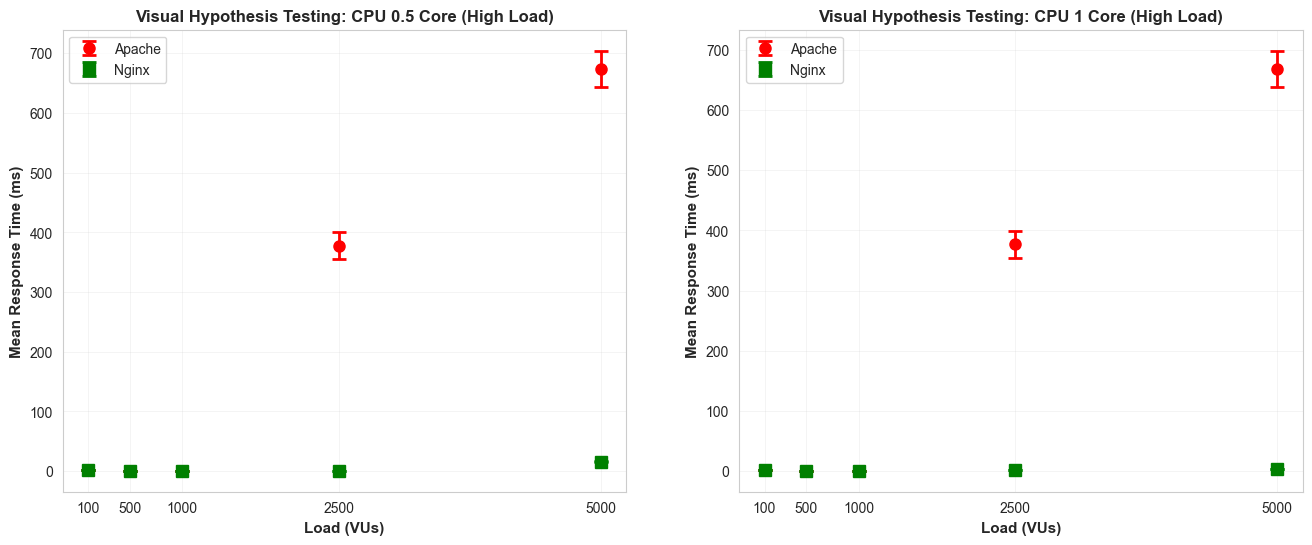

In [ ]:
def plot_mean_response_time_with_error_bars(ax, df):
    """
    Create error bar plots for mean response time comparison between Apache and Nginx.
    Shows 95% confidence interval of the mean for visual hypothesis testing.
    
    Error bars represent: mean ± 1.96 * (std / sqrt(n))
    where n is the number of requests measured.
    """
    # Separate data for each server
    apache_data = df[df['server'] == 'apache']
    nginx_data = df[df['server'] == 'nginx']
    
    apache_vus = apache_data["vus"]
    apache_mean = apache_data["success_mean_duration"]
    apache_margin_error = apache_data["confidence_level"]

    nginx_vus = nginx_data["vus"]
    nginx_mean = nginx_data["success_mean_duration"]
    nginx_margin_error = nginx_data["confidence_level"]
    
    # Plot error bars
    ax.errorbar(apache_vus, apache_mean, yerr=apache_margin_error, 
                fmt='o', color='red', markersize=8, capsize=5, capthick=2,
                label='Apache', linewidth=2, elinewidth=2)
    
    ax.errorbar(nginx_vus, nginx_mean, yerr=nginx_margin_error,
                fmt='s', color='green', markersize=8, capsize=5, capthick=2,
                label='Nginx', linewidth=2, elinewidth=2)
    
    # Styling
    ax.set_xlabel('Load (VUs)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Response Time (ms)', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_facecolor('white')
    
    # Set x-axis ticks
    ax.set_xticks(vu_levels)
    ax.set_xticklabels(vu_levels)
    return ax 


# ======================================================
# Plot Graph

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

cpu_scenarios = [
    (0.5, 'Visual Hypothesis Testing: CPU 0.5 Core (High Load)', df_ci_results_cpu05),
    (1.0, 'Visual Hypothesis Testing: CPU 1 Core (High Load)', df_ci_results_cpu10)
]

for idx, (cpu_limit, title, df_ci_result) in enumerate(cpu_scenarios):
    ax = axes[idx]
    plot_mean_response_time_with_error_bars(ax, df_ci_result)

plt.show()

ตารางที่ 10.1 และ 10.2 แสดงผลการเปรียบเทียบ Mean Response Time พร้อม 95% Confidence Interval ระหว่าง Apache และ Nginx ภายใต้ CPU 0.5 Core และ 1.0 Core ตามลำดับ โดยใช้หลัก Visual Hypothesis Testing ดังนี้

- ในกรณีที่ช่วงความเชื่อมั่น (Confidence Interval) **ไม่ทับซ้อนกัน (No Overlap)** สามารถสรุปได้ว่าประสิทธิภาพของ Web Server ทั้งสองแตกต่างกันอย่างมีนัยสำคัญทางสถิติที่ระดับความเชื่อมั่น 95%
- ในกรณีที่ช่วงความเชื่อมั่น **ทับซ้อนกัน (Overlap)** ไม่สามารถสรุปความแตกต่างอย่างมีนัยสำคัญทางสถิติได้

ผลการทดลองแสดงให้เห็นว่าในช่วง Load ต่ำ (เช่น 100 - 500 VUs) Performance ของ Apache และ Nginx มีความใกล้เคียงกัน อย่างไรก็ตาม เมื่อ Load เพิ่มสูงขึ้น (โดยเฉพาะที่ 2500 - 5000 VUs) Nginx มีแนวโน้มให้ Mean Response Time ต่ำกว่าและมี Confidence Interval แคบกว่า ซึ่งสะท้อนถึงความเสถียรของระบบที่ดีกว่า

## Capacity Curve & Usable Capacity

ในส่วนนี้ให้นักศึกษาวิเคราะห์ขีดความสามารถของระบบ (System Capacity) โดยใช้ **Capacity Curve** เพื่อหาจุดทำงานที่เหมาะสม (**Usable Capacity**) และจุดเปลี่ยนพฤติกรรมของระบบ (**Knee Point**)

In [25]:
df_results["throughput_mean"] = df_results["total_requests"] / df_results["test_duration"]

### ขั้นตอนที่ 1 : สร้าง Capacity Curve

ให้นักศึกษาสร้างกราฟจำนวน 1 ชุดต่อ 1 ระบบที่ทดสอบ โดยประกอบด้วยกราฟย่อย 2 กราฟ

**กราฟที่ 1: Throughput vs Load**

- แกน X: Load (VUs)
- แกน Y: Throughput (requests/sec)

**กราฟที่ 2: Response Time vs Load**

- แกน X: Load (VUs)
- แกน Y: Response Time (ms)
- แสดงอย่างน้อยค่า **p95** (และ p99 ถ้ามี)

> **หมายเหตุ:** ทั้งสองกราฟต้องใช้ค่า Load (VUs) ชุดเดียวกัน

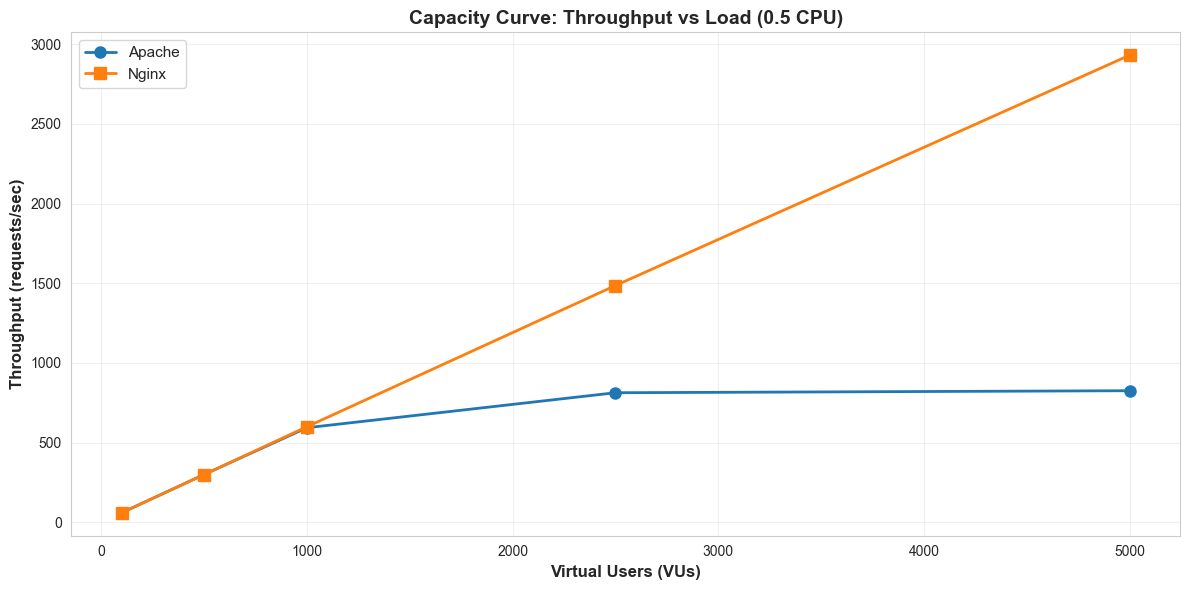

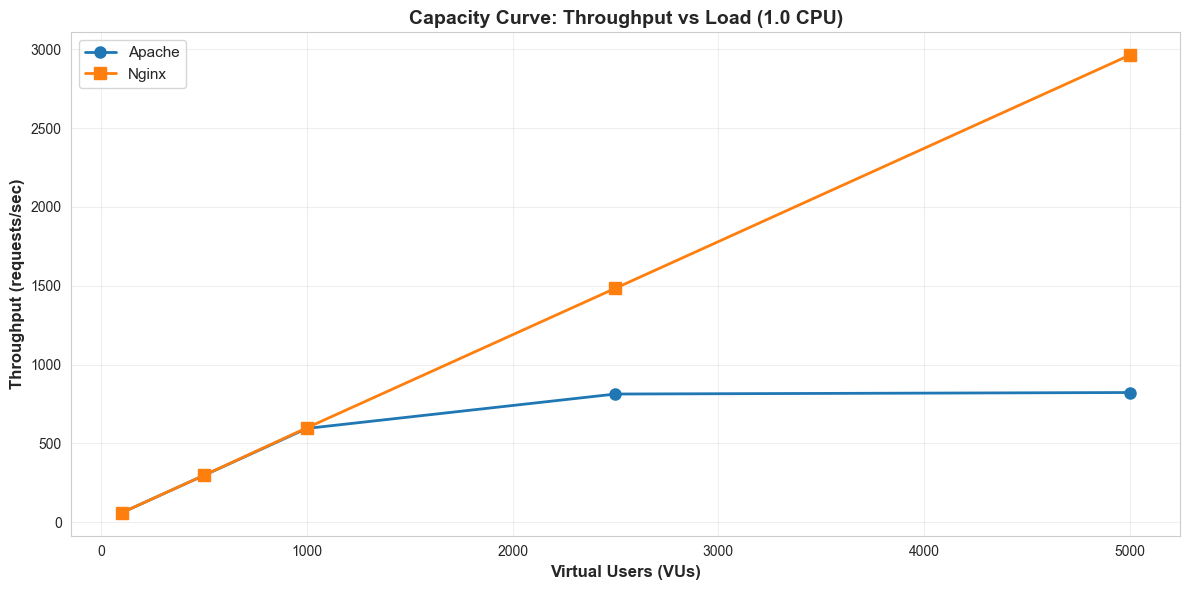

In [43]:
def plot_capacity_curve_throughput(df, cpu_limit):
    """
    Plot throughput vs VUs (load) for capacity analysis.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scenario_data = df[df['cpu_limit'] == cpu_limit]
    
    for server in ['apache', 'nginx']:
        server_data = scenario_data[scenario_data['server'] == server].sort_values('vus')
        
        vus = server_data['vus']
        throughput_mean = server_data['throughput_mean']
        
        # Plot line
        marker = 'o' if server == 'apache' else 's'
        ax.plot(vus, throughput_mean, marker=marker, linewidth=2, markersize=8, label=server.capitalize())
    
    ax.set_xlabel('Virtual Users (VUs)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Throughput (requests/sec)', fontsize=12, fontweight='bold')
    ax.set_title(f'Capacity Curve: Throughput vs Load ({cpu_limit} CPU)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot for both scenarios
for cpu in [0.5, 1.0]:
    plot_capacity_curve_throughput(df_results, cpu)
    plt.show()

### ขั้นตอนที่ 2: กำหนด Response Time Limit

ให้นักศึกษากำหนด Response Time Threshold ที่ยอมรับได้ เช่น

- **p95 ≤ 500 ms**

จากนั้นให้วาดเส้นแนวนอน (Horizontal Line) บนกราฟ Response Time เพื่อใช้เป็นเกณฑ์ตัดสิน Usable Capacity

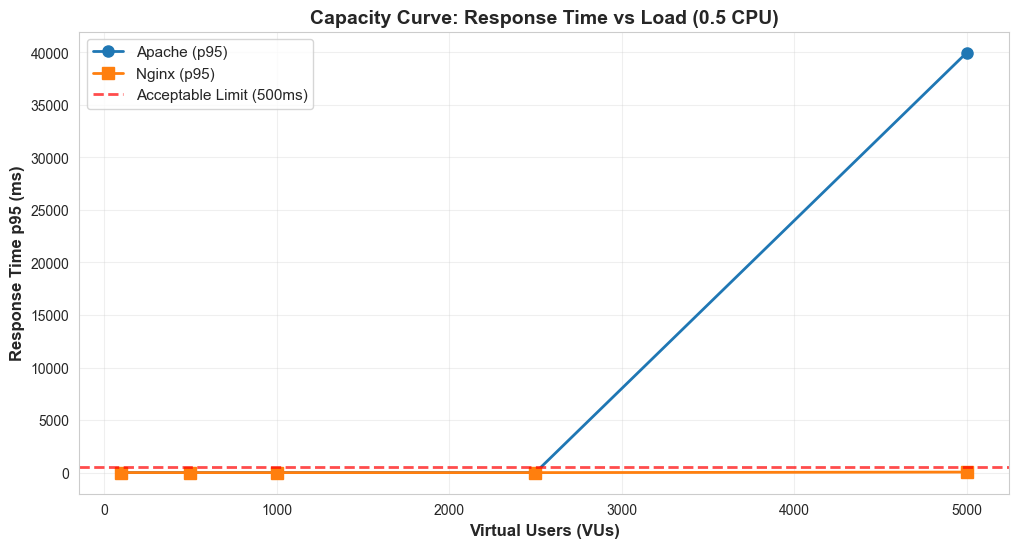

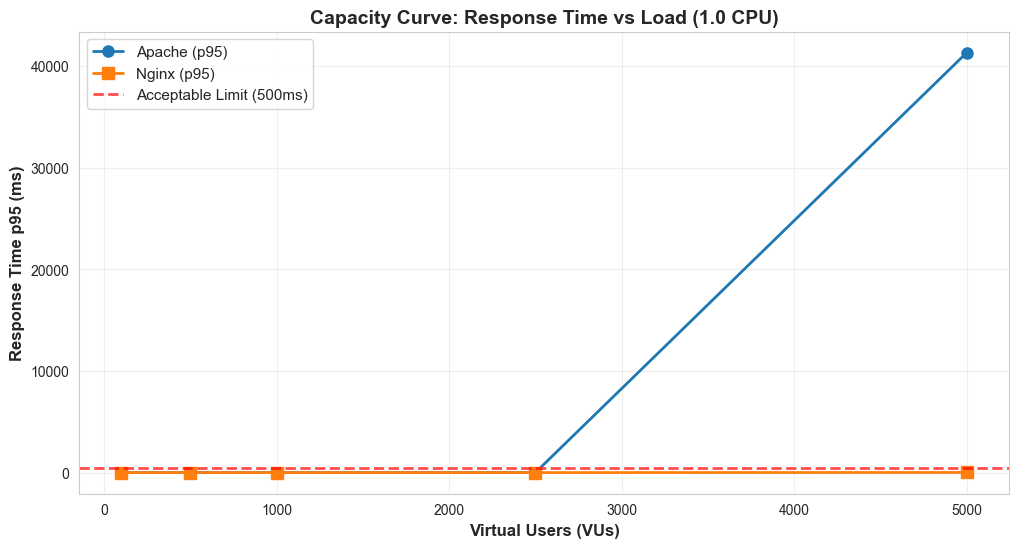

In [50]:
def plot_capacity_curve_response_time(df, cpu_limit, response_time_limit=500):
    """
    Plot response time (p95) vs VUs with acceptable threshold line.
    
    Args:
        df: DataFrame with results
        cpu_limit: CPU limit to filter
        response_time_limit: Acceptable p95 response time threshold in ms
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    scenario_data = df[df['cpu_limit'] == cpu_limit]
    
    for server in ['apache', 'nginx']:
        server_data = scenario_data[scenario_data['server'] == server].sort_values('vus')
        
        vus = server_data['vus']
        
        # Plot line
        marker = 'o' if server == 'apache' else 's'
        ax.plot(vus, server_data['p95_duration'], marker=marker, linewidth=2, markersize=8, label=f'{server.capitalize()} (p95)')
    
    # Add acceptable threshold line
    ax.axhline(y=response_time_limit, color='red', linestyle='--', linewidth=2, 
               label=f'Acceptable Limit ({response_time_limit}ms)', alpha=0.7)
    
    ax.set_xlabel('Virtual Users (VUs)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Response Time p95 (ms)', fontsize=12, fontweight='bold')
    ax.set_title(f'Capacity Curve: Response Time vs Load ({cpu_limit} CPU)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    return fig

# Plot for both scenarios
for cpu in [0.5, 1.0]:
    plot_capacity_curve_response_time(df_results, cpu, response_time_limit=500)
    plt.show()

### ขั้นตอนที่ 3: ระบุ Knee Point

ให้นักศึกษาพิจารณากราฟทั้งสองร่วมกัน และระบุ **Knee Point** โดยใช้เกณฑ์ดังนี้

- **ก่อน Knee Point:** Throughput เพิ่มขึ้นชัดเจน แต่ Response Time เพิ่มขึ้นช้า
- **หลัง Knee Point:** Throughput เพิ่มขึ้นน้อยหรือคงที่ แต่ Response Time เพิ่มขึ้นอย่างรวดเร็ว

In [52]:
def find_knee_point(df, server, cpu_limit, response_time_limit=500):
    """
    Find the knee point where throughput plateaus and response time exceeds threshold.
    
    Returns:
        Dictionary with knee point analysis
    """
    server_data = df[(df['server'] == server) & (df['cpu_limit'] == cpu_limit)].sort_values('vus')
    
    if len(server_data) == 0:
        return None
    
    # Find where p95 exceeds threshold
    exceeds_threshold = server_data[server_data['p95_duration'] > response_time_limit]
    
    if len(exceeds_threshold) > 0:
        knee_vus = exceeds_threshold.iloc[0]['vus']
        # Usable capacity is the VU level just before knee point
        usable_capacity_idx = server_data[server_data['vus'] < knee_vus].index
        if len(usable_capacity_idx) > 0:
            usable_capacity = server_data.loc[usable_capacity_idx[-1]]
        else:
            usable_capacity = None
    else:
        knee_vus = None
        usable_capacity = server_data.iloc[-1]  # All loads are acceptable
    
    # Calculate throughput efficiency (throughput per VU)
    server_data['efficiency'] = server_data['throughput_mean'] / server_data['vus']
    
    result = {
        'server': server,
        'cpu_limit': cpu_limit,
        'knee_point_vus': knee_vus,
        'max_throughput': server_data['throughput_mean'].max(),
        'peak_efficiency': server_data['efficiency'].max(),
    }
    
    if usable_capacity is not None:
        result.update({
            'usable_capacity_vus': usable_capacity['vus'],
            'usable_throughput': usable_capacity['throughput_mean'],
            'usable_p95_response': usable_capacity['p95_duration'],
        })
    
    return result

# Find knee points for all configurations
knee_points = []
for cpu in [0.5, 1.0]:
    for server in ['apache', 'nginx']:
        kp = find_knee_point(df_results, server, cpu, response_time_limit=500)
        if kp:
            knee_points.append(kp)

df_knee_points = pd.DataFrame(knee_points)

print("\n" + "="*80)
print("KNEE POINT ANALYSIS & USABLE CAPACITY")
print("="*80)
df_knee_points


KNEE POINT ANALYSIS & USABLE CAPACITY


,server,cpu_limit,knee_point_vus,max_throughput,peak_efficiency,usable_capacity_vus,usable_throughput,usable_p95_response
0,apache,0.5,5000.0,825.720588,0.599917,2500,813.015873,3.27268
1,nginx,0.5,NaN,2931.057377,0.603333,5000,2931.057377,52.10418
2,apache,1.0,5000.0,822.510949,0.599504,2500,812.913386,5.13211
3,nginx,1.0,NaN,2962.204918,0.598926,5000,2962.204918,15.29590


## 8. Side-by-Side Comparison: Apache vs Nginx


SCENARIO: 0.5 CPU


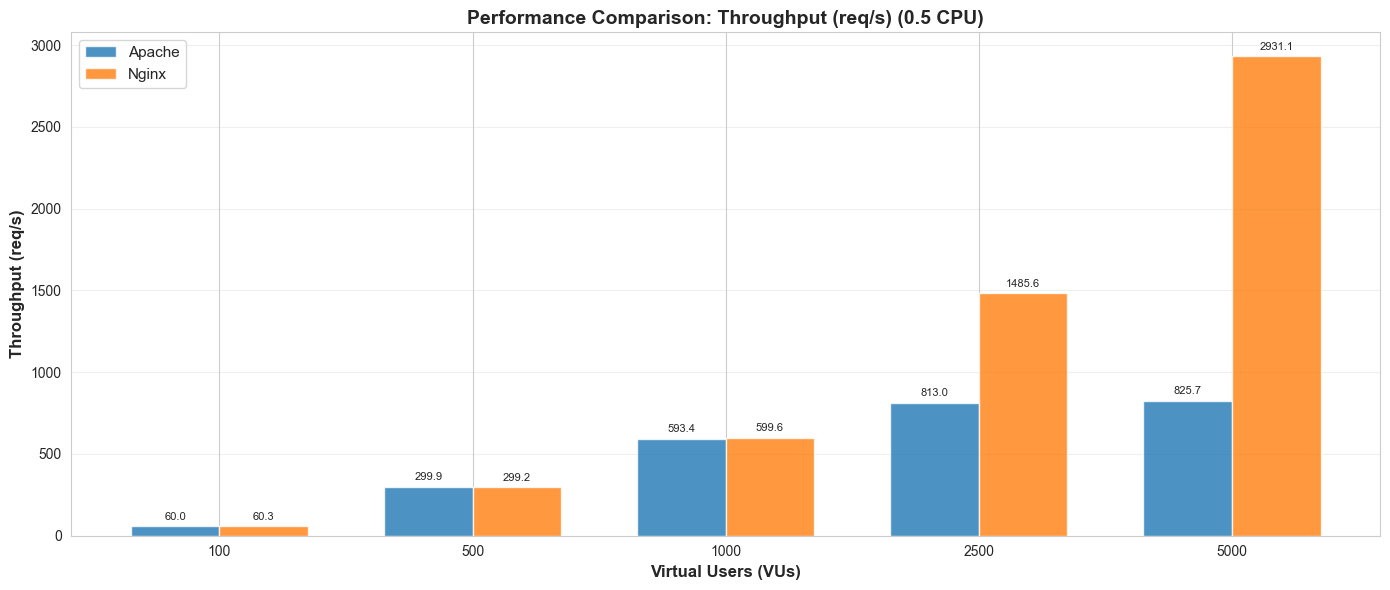

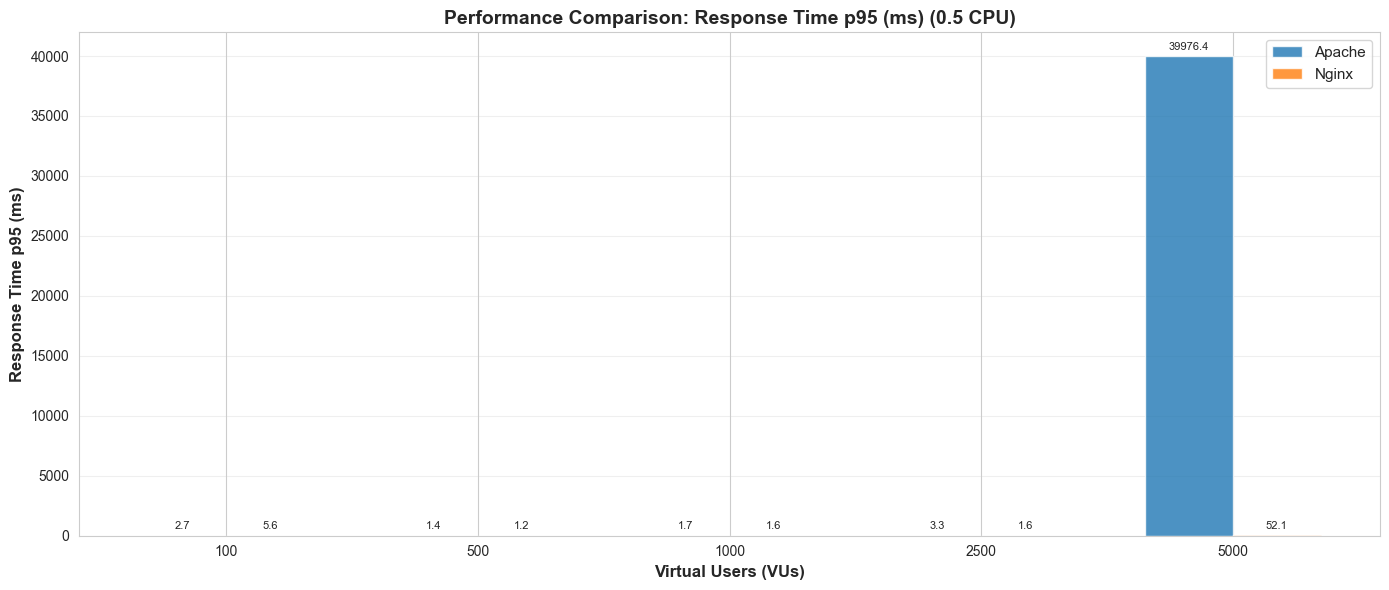


SCENARIO: 1.0 CPU


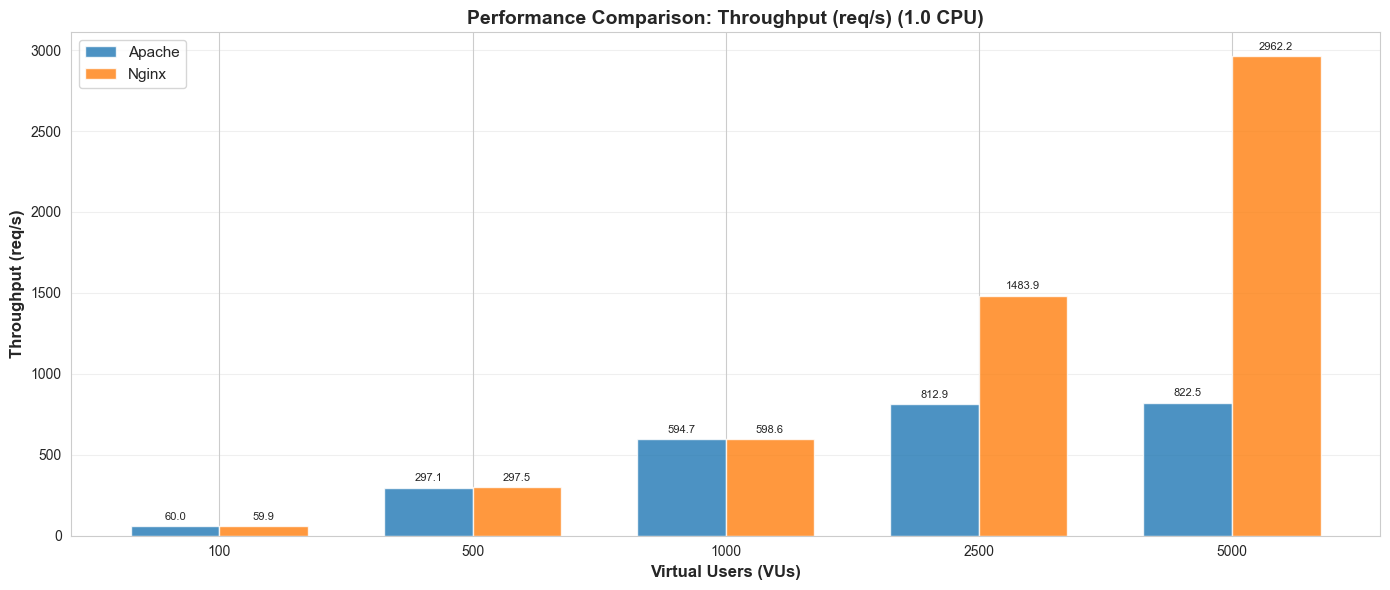

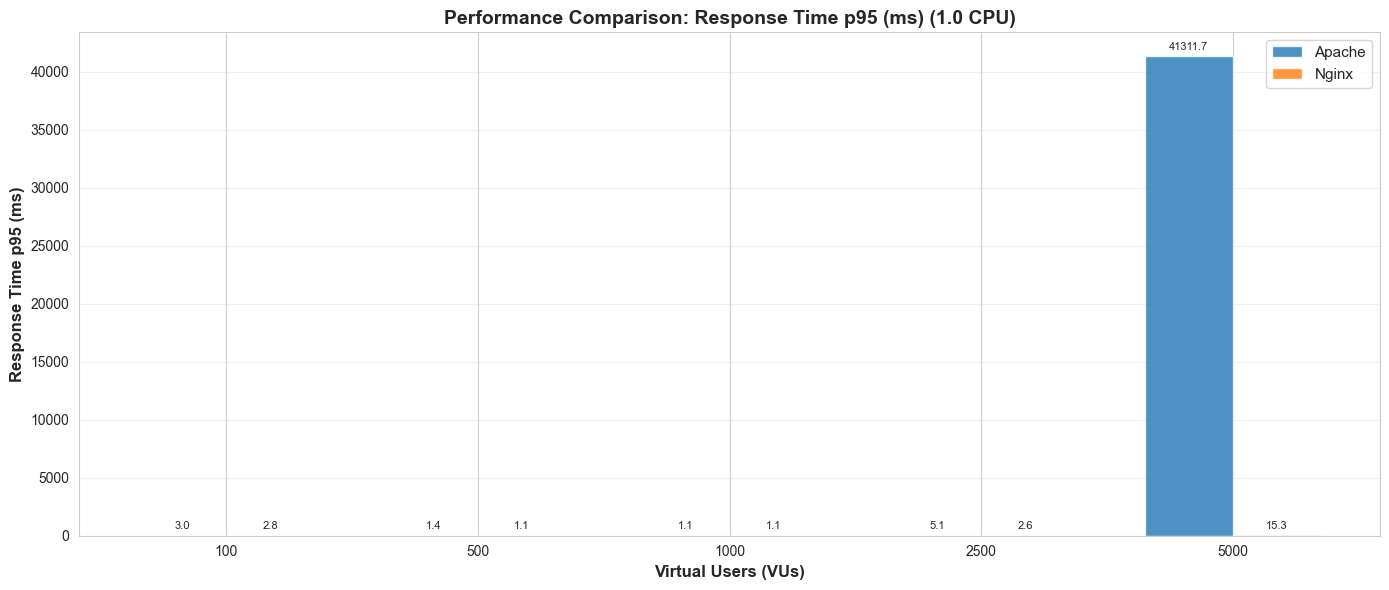

In [36]:
def plot_server_comparison(df, cpu_limit, metric='throughput_mean', ylabel='Throughput (req/s)'):
    """
    Create side-by-side bar chart comparing Apache and Nginx.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    scenario_data = df[df['cpu_limit'] == cpu_limit]
    
    x = np.arange(len(vu_levels))
    width = 0.35
    
    apache_data = scenario_data[scenario_data['server'] == 'apache'].sort_values('vus')
    nginx_data = scenario_data[scenario_data['server'] == 'nginx'].sort_values('vus')
    
    bars1 = ax.bar(x - width/2, apache_data[metric], width, label='Apache', alpha=0.8)
    bars2 = ax.bar(x + width/2, nginx_data[metric], width, label='Nginx', alpha=0.8)
    
    ax.set_xlabel('Virtual Users (VUs)', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.set_title(f'Performance Comparison: {ylabel} ({cpu_limit} CPU)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(vu_levels)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    return fig

# Create comparison charts
for cpu in [0.5, 1.0]:
    print(f"\n{'='*80}")
    print(f"SCENARIO: {cpu} CPU")
    print(f"{'='*80}")
    
    plot_server_comparison(df_results, cpu, 'throughput_mean', 'Throughput (req/s)')
    plt.show()
    
    plot_server_comparison(df_results, cpu, 'p95_duration', 'Response Time p95 (ms)')
    plt.show()
    
    # plot_server_comparison(df_results, cpu, 'error_rate_mean', 'Error Rate (%)')
    # plt.show()

In [ ]:
def plot_confidence_intervals(df, cpu_limit, metric='throughput'):
    """
    Plot confidence intervals for visual hypothesis testing.
    Overlapping CIs suggest no significant difference.
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    scenario_data = df_results[(df_results['cpu_limit'] == cpu_limit)]
    
    y_pos = 0
    yticks = []
    yticklabels = []
    
    for vus in vu_levels:
        for server in ['apache', 'nginx']:
            data = scenario_data[(scenario_data['vus'] == vus) & (scenario_data['server'] == server)][metric]
            
            if len(data) > 0:
                mean, lower, upper, moe = calculate_confidence_interval(data.values)
                
                color = 'blue' if server == 'apache' else 'green'
                ax.errorbar(mean, y_pos, xerr=[[mean-lower], [upper-mean]], 
                           fmt='o', color=color, capsize=5, capthick=2, markersize=8)
                
                yticks.append(y_pos)
                yticklabels.append(f"{server.capitalize()}\n{vus} VUs")
                y_pos += 1
        
        y_pos += 0.5  # Add spacing between VU groups
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_title(f'95% Confidence Intervals: {metric.replace("_", " ").title()} ({cpu_limit} CPU)', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='blue', label='Apache'),
                      Patch(facecolor='green', label='Nginx')]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    return fig

# Plot confidence intervals for key metrics
for cpu in [0.5, 1.0]:
    print(f"\n{'='*80}")
    print(f"95% Confidence Intervals - {cpu} CPU")
    print(f"{'='*80}")
    
    if 'throughput' in df_results.columns:
        plot_confidence_intervals(df_results, cpu, 'throughput')
        plt.show()
    
    if 'p95_duration' in df_results.columns:
        plot_confidence_intervals(df_results, cpu, 'p95_duration')
        plt.show()

## 10. Performance Summary Table

In [ ]:
def create_summary_table(df):
    """
    Create a comprehensive summary table.
    """
    summary = df.pivot_table(
        index=['cpu_limit', 'vus'],
        columns='server',
        values=['throughput_mean', 'p95_duration_mean', 'error_rate_mean'],
        aggfunc='first'
    )
    
    return summary

summary_table = create_summary_table(df_summary)

print("\n" + "="*100)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*100)
print("\nThroughput (req/s) | Response Time p95 (ms) | Error Rate (%)")
print("="*100)
summary_table

## 11. Key Findings and Recommendations

In [ ]:
print("\n" + "="*100)
print("KEY FINDINGS")
print("="*100)

for cpu in [0.5, 1.0]:
    print(f"\n### Scenario: {cpu} CPU Core(s)\n")
    
    scenario_knee = df_knee_points[df_knee_points['cpu_limit'] == cpu]
    
    for _, row in scenario_knee.iterrows():
        server = row['server'].capitalize()
        print(f"**{server}:**")
        print(f"  - Maximum Throughput: {row['max_throughput']:.2f} req/s")
        
        if pd.notna(row.get('knee_point_vus')):
            print(f"  - Knee Point: {row['knee_point_vus']} VUs")
        else:
            print(f"  - Knee Point: Not reached (response time acceptable at all loads)")
        
        if pd.notna(row.get('usable_capacity_vus')):
            print(f"  - Usable Capacity: {row['usable_capacity_vus']} VUs")
            print(f"  - Usable Throughput: {row['usable_throughput']:.2f} req/s")
            print(f"  - Response Time at Capacity: {row['usable_p95_response']:.2f} ms (p95)")
        
        print()

print("\n" + "="*100)
print("RECOMMENDATIONS")
print("="*100)
print("""
1. **Resource Allocation**: Compare the usable capacity between 0.5 and 1.0 CPU scenarios
   to determine the cost-benefit of additional resources.

2. **Server Selection**: Choose the server (Apache vs Nginx) that provides better throughput
   and lower response times at your expected load level.

3. **Capacity Planning**: Deploy enough instances to stay below the knee point with headroom
   for traffic spikes (typically 60-70% of usable capacity).

4. **Performance Monitoring**: Set alerts when p95 response time exceeds 400ms (80% of 500ms
   threshold) to proactively scale before hitting capacity limits.

5. **Load Testing**: Regularly repeat these tests as application code changes, as even small
   modifications can significantly impact performance characteristics.
""")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)

## 12. Export Results for Further Analysis

In [ ]:
# Export summary tables to CSV
df_summary.to_csv('performance_summary.csv', index=False)
df_knee_points.to_csv('knee_points_analysis.csv', index=False)

print("\nResults exported:")
print("  - performance_summary.csv")
print("  - knee_points_analysis.csv")
print("\nAnalysis complete! Review the visualizations and tables above.")